Batch 10, Loss: 0.6522
Batch 20, Loss: 0.2912
Batch 30, Loss: 0.8451
Batch 40, Loss: 0.3712
Batch 50, Loss: 0.3155
Batch 60, Loss: 0.4663
Batch 70, Loss: 0.1033
Batch 80, Loss: 0.4339
Batch 90, Loss: 0.2629
Batch 100, Loss: 0.4518
Batch 110, Loss: 0.3577
Batch 120, Loss: 0.2938
Batch 130, Loss: 0.7228
Batch 140, Loss: 0.0703
Batch 150, Loss: 0.4698
Batch 160, Loss: 0.1896
Batch 170, Loss: 0.1967
Batch 180, Loss: 0.1221
Batch 190, Loss: 0.3323
Batch 200, Loss: 0.5220
Batch 210, Loss: 0.3492
Batch 220, Loss: 0.3344
Batch 230, Loss: 0.4354
Batch 240, Loss: 0.3740
Batch 250, Loss: 0.2221
Batch 260, Loss: 0.1831
Batch 270, Loss: 0.2494
Batch 280, Loss: 0.8023
Batch 290, Loss: 0.5568
Batch 300, Loss: 0.0056
Batch 310, Loss: 0.6470
Batch 320, Loss: 0.5197
Batch 330, Loss: 0.6959
Batch 340, Loss: 0.2452

Detailed Evaluation:
Fresh Accuracy: 0.8899 (4218/4740)
Rotten Accuracy: 0.8947 (5512/6161)
Fresh threshold: 0.2428, Rotten threshold: 0.2174

Detailed Evaluation:
Fresh Accuracy: 0.8866 (1032

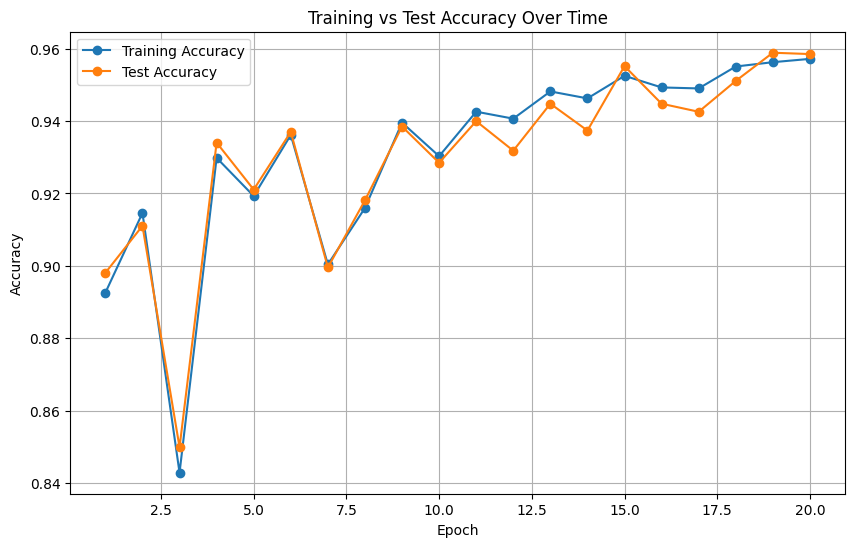

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt  # Added for plotting

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Hyperparameters
LEARNING_RATE = 0.0001 
NUM_EPOCHS = 20
BATCH_SIZE = 32        
EMBEDDING_DIM = 128    

# Minimal data transformations
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),  # Keep minimal augmentation for robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Improved encoder architecture
class ImprovedEncoder(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super(ImprovedEncoder, self).__init__()
        
        # Use ResNet-like blocks for better feature extraction
        def conv_block(in_channels, out_channels, pool=False):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)
        
        self.conv_layers = nn.Sequential(
            conv_block(3, 64, pool=True),      # 64x32x32
            conv_block(64, 128, pool=True),    # 128x16x16
            conv_block(128, 256, pool=True),   # 256x8x8
            conv_block(256, 512, pool=True),   # 512x4x4
            nn.AdaptiveAvgPool2d((1, 1))      # 512x1x1
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512, embedding_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(embedding_dim),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

def train_epoch(encoder, train_loader, optimizer, class_names):
    encoder.train()
    total_loss = 0
    num_batches = 0
    
    for images, labels in train_loader:
        # Convert string labels to binary (0 for fresh, 1 for rotten)
        binary_labels = torch.tensor([1 if 'rotten' in class_names[label].lower() else 0 for label in labels])
        
        # Calculate class weights for this batch
        fresh_count = (binary_labels == 0).sum()
        rotten_count = (binary_labels == 1).sum()
        total_count = len(binary_labels)
        
        # Compute balanced weights
        fresh_weight = total_count / (2 * fresh_count) if fresh_count > 0 else 0
        rotten_weight = total_count / (2 * rotten_count) if rotten_count > 0 else 0
        
        optimizer.zero_grad()
        embeddings = encoder(images)
        
        loss = 0
        pair_count = 0
        
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                same_class = binary_labels[i] == binary_labels[j]
                distance = 1 - F.cosine_similarity(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0))
                
                # Apply class-weighted loss
                if same_class:
                    weight = fresh_weight if binary_labels[i] == 0 else rotten_weight
                    loss += weight * distance
                else:
                    # For different classes, use average of both weights
                    weight = (fresh_weight + rotten_weight) / 2
                    margin = 1.0  # Increased margin for better separation
                    loss += weight * torch.clamp(2.0 - distance, min=0.0)  # Push different classes further apart
                
                pair_count += 1
        
        if pair_count > 0:
            loss = loss / pair_count
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
            
            if num_batches % 10 == 0:
                print(f'Batch {num_batches}, Loss: {loss.item():.4f}')
    
    return total_loss / num_batches if num_batches > 0 else 0
    
    return total_loss / num_batches if num_batches > 0 else 0

def evaluate(encoder, test_loader, class_names):
    encoder.eval()
    correct = 0
    total = 0
    fresh_correct = 0
    fresh_total = 0
    rotten_correct = 0
    rotten_total = 0
    
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            embeddings = encoder(images)
            all_embeddings.append(embeddings)
            all_labels.extend([1 if 'rotten' in class_names[label].lower() else 0 for label in labels])
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.tensor(all_labels)
    
    # Compute class centroids
    fresh_mask = all_labels == 0
    rotten_mask = all_labels == 1
    fresh_centroid = all_embeddings[fresh_mask].mean(dim=0, keepdim=True)
    rotten_centroid = all_embeddings[rotten_mask].mean(dim=0, keepdim=True)
    
    # Compute average distances within each class
    fresh_distances = 1 - F.cosine_similarity(all_embeddings[fresh_mask].unsqueeze(1), fresh_centroid)
    rotten_distances = 1 - F.cosine_similarity(all_embeddings[rotten_mask].unsqueeze(1), rotten_centroid)
    
    # Use these to set adaptive thresholds
    fresh_threshold = fresh_distances.mean().item()
    rotten_threshold = rotten_distances.mean().item()
    
    # Evaluate each sample with balanced thresholds
    for i in range(len(all_embeddings)):
        embedding = all_embeddings[i].unsqueeze(0)
        label = all_labels[i]
        
        # Compute normalized distances to centroids
        fresh_dist = (1 - F.cosine_similarity(embedding, fresh_centroid)) / fresh_threshold
        rotten_dist = (1 - F.cosine_similarity(embedding, rotten_centroid)) / rotten_threshold
        
        # Predict class based on balanced distances
        pred = 1 if rotten_dist < fresh_dist else 0
        
        if label == 0:  # fresh
            fresh_total += 1
            if pred == label:
                fresh_correct += 1
        else:  # rotten
            rotten_total += 1
            if pred == label:
                rotten_correct += 1
        
        if pred == label:
            correct += 1
        total += 1
    
    fresh_acc = fresh_correct/fresh_total if fresh_total > 0 else 0
    rotten_acc = rotten_correct/rotten_total if rotten_total > 0 else 0
    
    print(f"\nDetailed Evaluation:")
    print(f"Fresh Accuracy: {fresh_acc:.4f} ({fresh_correct}/{fresh_total})")
    print(f"Rotten Accuracy: {rotten_acc:.4f} ({rotten_correct}/{rotten_total})")
    print(f"Fresh threshold: {fresh_threshold:.4f}, Rotten threshold: {rotten_threshold:.4f}")
    
    return correct / total
    
    overall_acc = correct / total if total > 0 else 0
    fresh_acc = fresh_correct / fresh_total if fresh_total > 0 else 0
    rotten_acc = rotten_correct / rotten_total if rotten_total > 0 else 0
    
    print(f"\nDetailed Evaluation:")
    print(f"Fresh Accuracy: {fresh_acc:.4f} ({fresh_correct}/{fresh_total})")
    print(f"Rotten Accuracy: {rotten_acc:.4f} ({rotten_correct}/{rotten_total})")
    
    return overall_acc

def main():
    # Load datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=train_transform)
    test_dataset = datasets.ImageFolder(root='data/test', transform=test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    class_names = train_dataset.classes
    
    # Initialize model and optimizer
    encoder = ImprovedEncoder()
    optimizer = torch.optim.AdamW(encoder.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    
    # Lists to store accuracies for plotting
    train_accuracies = []
    test_accuracies = []
    epochs = []
    
    # Training loop
    best_accuracy = 0
    for epoch in range(NUM_EPOCHS):
        # Training
        loss = train_epoch(encoder, train_loader, optimizer, class_names)
        
        # Evaluate on both train and test sets
        train_accuracy = evaluate(encoder, train_loader, class_names)
        test_accuracy = evaluate(encoder, test_loader, class_names)
        
        # Store accuracies for plotting
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        epochs.append(epoch + 1)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(encoder.state_dict(), 'best_model.pth')
    
    print(f'Best Test Accuracy: {best_accuracy:.4f}')
    
    # Plot accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Test Accuracy Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()